# Creating the same Time Series model, with the use of categories to produce a more accurate forecast


## This model was created with the same steps as the "TimeSeriesForecastTry-XGBoost" notebook, but the dataset that was used is different.
## Here the data was split into categories, to examine the "Accessories" products forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

C:\Users\hasan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('Accessories_NetGrossProfit.csv')
df = df.set_index('Transaction Date')
df.index = pd.to_datetime(df.index)

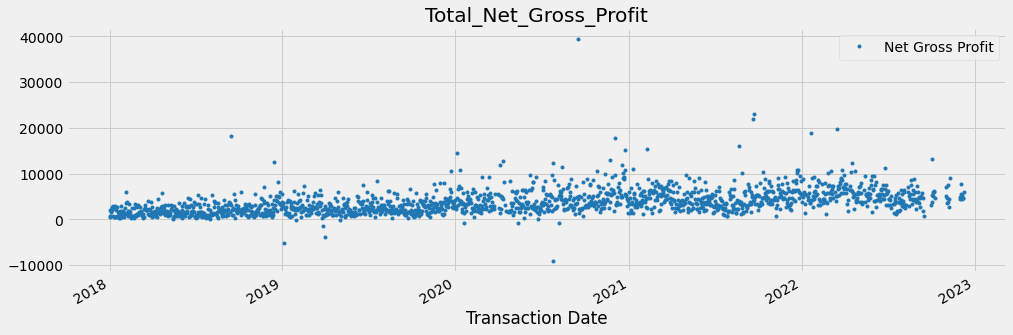

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Total_Net_Gross_Profit')
plt.show()

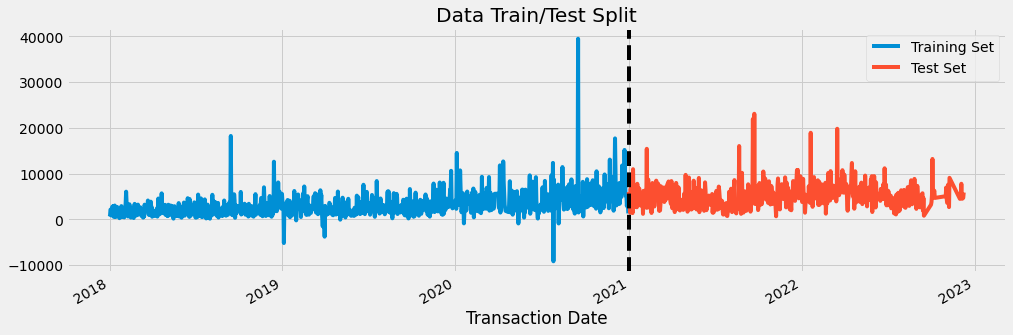

In [4]:
train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

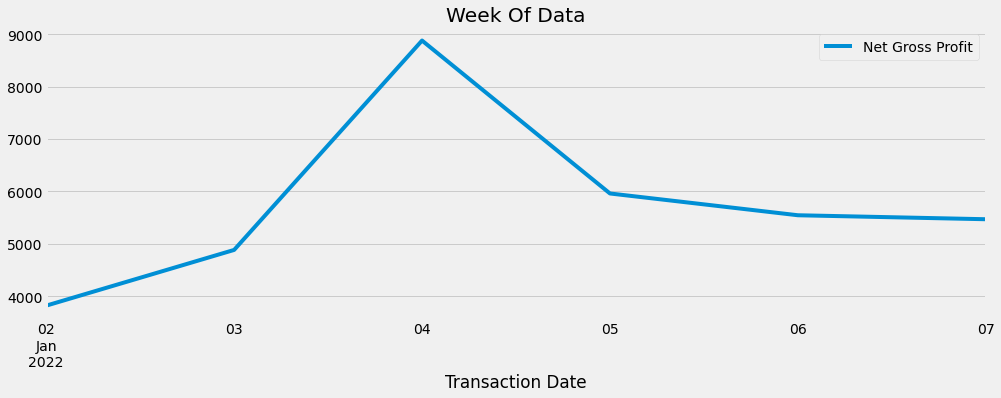

In [5]:
df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

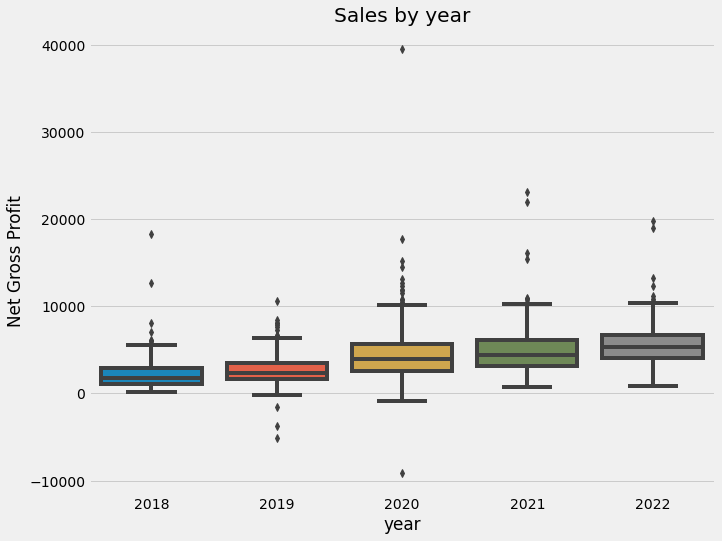

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Net Gross Profit')
ax.set_title('Sales by year')
plt.show()

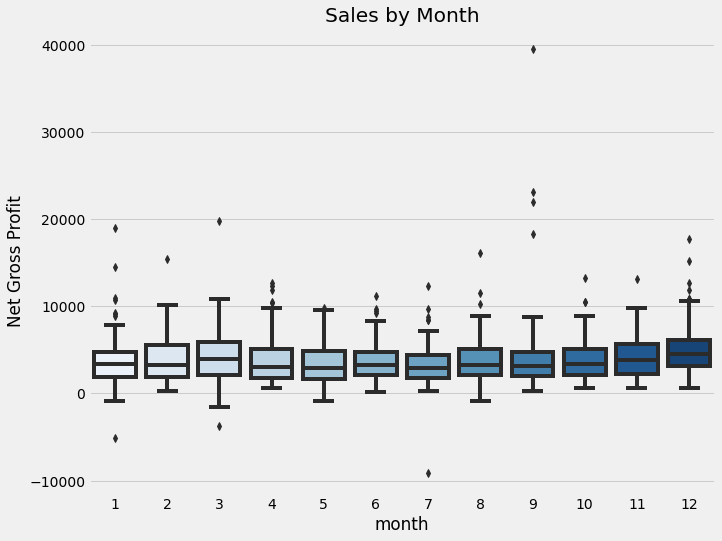

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Net Gross Profit', palette='Blues')
ax.set_title('Sales by Month')
plt.show()

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Net Gross Profit'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [10]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[09:42:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3964.67447	validation_1-rmse:5661.17183
[100]	validation_0-rmse:2498.64747	validation_1-rmse:3423.00917
[200]	validation_0-rmse:2166.79141	validation_1-rmse:2863.44301
[300]	validation_0-rmse:2070.20778	validation_1-rmse:2743.02370
[400]	validation_0-rmse:2030.36922	validation_1-rmse:2719.89031
[489]	validation_0-rmse:1998.31324	validation_1-rmse:2719.43367


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

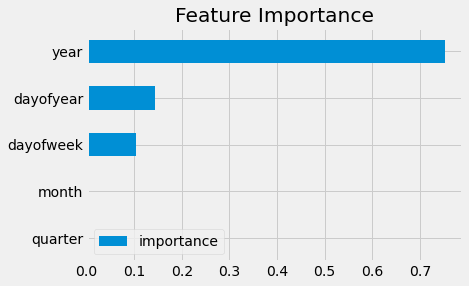

In [11]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

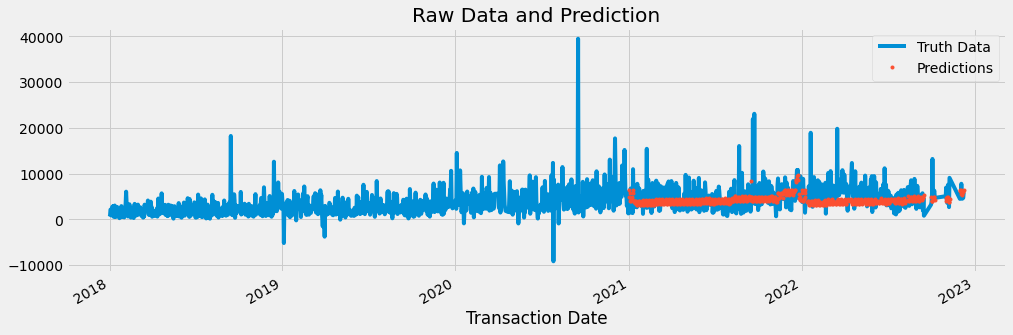

In [12]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Net Gross Profit']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

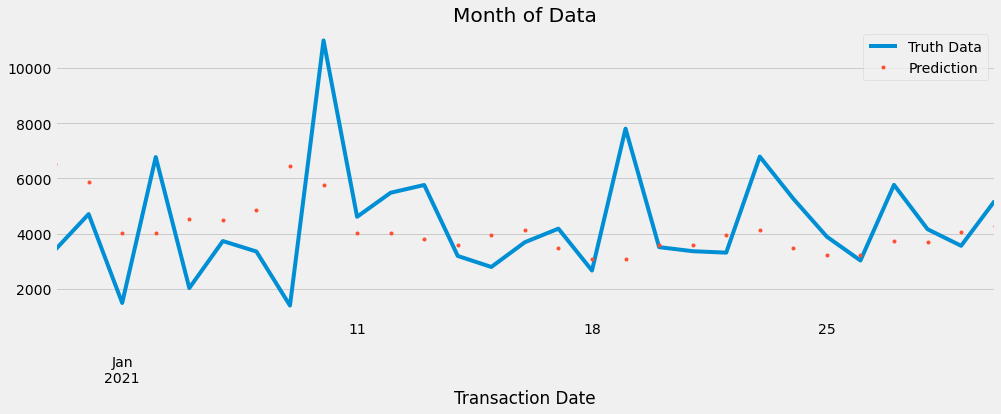

In [13]:


ax = df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['Net Gross Profit'] \
    .plot(figsize=(15, 5), title='Month of Data')
df.loc[(df.index > '01-01-2021') & (df.index < '31-01-2021')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()



In [14]:
score = np.sqrt(mean_squared_error(test['Net Gross Profit'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2718.68


In [15]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2021-09-23    18515.357042
2021-09-20    17936.971615
2022-03-17    15879.203595
2022-01-20    15376.158236
2021-02-08    12228.551963
2021-08-22    11841.602146
2022-10-04     9199.242055
2022-04-17     8498.818089
2022-03-28     7312.310820
2022-06-25     6805.829509
Name: error, dtype: float64

<AxesSubplot:ylabel='Frequency'>

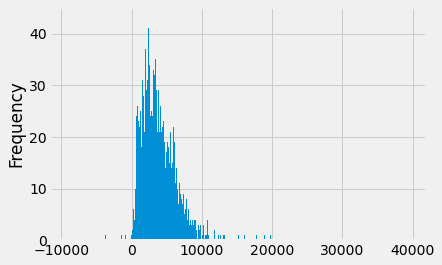

In [16]:
df['Net Gross Profit'].plot(kind='hist', bins=500)

In [17]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()



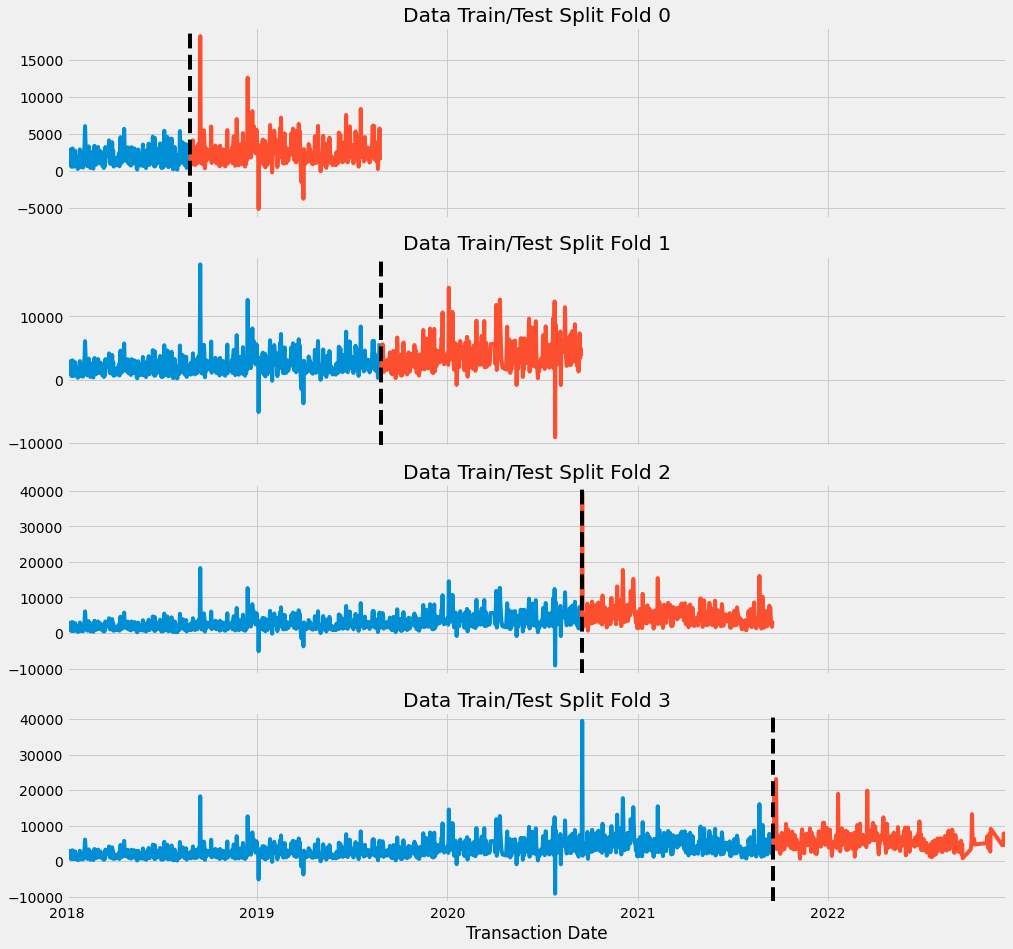

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Net Gross Profit'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Net Gross Profit'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [19]:
def add_lags(df):
    target_map = df['Net Gross Profit'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('546 days')).map(target_map)
    return df

In [20]:
df = add_lags(df)

In [21]:
tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
    TARGET = 'Net Gross Profit'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[09:42:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2132.16588	validation_1-rmse:3150.57854
[100]	validation_0-rmse:1238.88759	validation_1-rmse:2280.89105
[200]	validation_0-rmse:1008.61021	validation_1-rmse:2035.65159
[300]	validation_0-rmse:932.12959	validation_1-rmse:1958.24875
[400]	validation_0-rmse:885.37909	validation_1-rmse:1930.79897
[500]	validation_0-rmse:852.15256	validation_1-rmse:1919.09789
[600]	validation_0-rmse:827.68796	validation_1-rmse:1917.78996
[667]	validation_0-rmse:810.91060	validation_1-rmse:1921.20066
[09:42:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2791.05945	

In [22]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2659.4801
Fold scores:[1917.7620722675656, 2576.9261513998476, 3233.5789544672753, 2909.6532089790057]


In [23]:
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2']
TARGET = 'Net Gross Profit'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=650,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[09:43:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4657.70036
[100]	validation_0-rmse:2716.98251
[200]	validation_0-rmse:2280.57125
[300]	validation_0-rmse:2167.81095
[400]	validation_0-rmse:2113.93586
[500]	validation_0-rmse:2089.84158
[600]	validation_0-rmse:2062.00185
[649]	validation_0-rmse:2050.42341


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=650, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [24]:
df.index.max()

Timestamp('2022-12-09 00:00:00')

In [25]:
future = pd.date_range('2022-12-09','2023-12-09', freq='24h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [26]:
future_w_features = df_and_future.query('isFuture').copy()

In [27]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

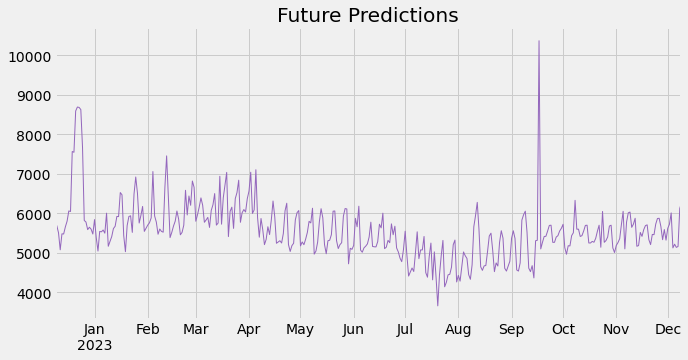

In [28]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [29]:
future_w_features

,Net Gross Profit,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,isFuture,pred
2022-12-09,NaN,4,4,12,2022,343,9,49,NaN,2015.540538,8114.209089,True,5516.136230
2022-12-10,NaN,5,4,12,2022,344,10,49,NaN,4790.210015,6483.139728,True,5689.673828
2022-12-11,NaN,6,4,12,2022,345,11,49,NaN,5904.131568,3792.745996,True,5508.777832
2022-12-12,NaN,0,4,12,2022,346,12,50,NaN,6366.462843,2029.987735,True,5077.911133
2022-12-13,NaN,1,4,12,2022,347,13,50,NaN,8399.978242,3363.003744,True,5481.633301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,NaN,1,4,12,2023,339,5,49,NaN,4525.363601,8114.896757,True,5219.461914
2023-12-06,NaN,2,4,12,2023,340,6,49,NaN,4679.538906,4233.243676,True,5138.846191
2023-12-07,NaN,3,4,12,2023,341,7,49,NaN,4720.954751,5372.455365,True,5162.099609
2023-12-08,NaN,4,4,12,2023,342,8,49,NaN,NaN,NaN,True,6125.093262


In [30]:
col1 = future_w_features['pred']
Prediction_df = pd.DataFrame({'Net Gross Profit': col1})

Prediction_df

,Net Gross Profit
2022-12-09,5516.136230
2022-12-10,5689.673828
2022-12-11,5508.777832
2022-12-12,5077.911133
2022-12-13,5481.633301
...,...
2023-12-05,5219.461914
2023-12-06,5138.846191
2023-12-07,5162.099609
2023-12-08,6125.093262


In [31]:
Historical_Pred_df = pd.concat([df, Prediction_df], axis=0)

In [32]:
Historical_Pred_df

,Net Gross Profit,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,isFuture
2018-01-01,593.730669,0.0,1.0,1.0,2018.0,1.0,1.0,1,NaN,NaN,NaN,False
2018-01-02,792.544456,1.0,1.0,1.0,2018.0,2.0,2.0,1,NaN,NaN,NaN,False
2018-01-03,2157.490106,2.0,1.0,1.0,2018.0,3.0,3.0,1,NaN,NaN,NaN,False
2018-01-04,2011.865010,3.0,1.0,1.0,2018.0,4.0,4.0,1,NaN,NaN,NaN,False
2018-01-05,1722.942144,4.0,1.0,1.0,2018.0,5.0,5.0,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,5219.461914,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2023-12-06,5138.846191,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2023-12-07,5162.099609,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2023-12-08,6125.093262,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN


In [33]:
Historical_Pred_df = Historical_Pred_df[['Net Gross Profit']]

In [34]:
Historical_Pred_df.rename_axis("Transaction Date", axis=0, inplace=True)

In [35]:
Historical_Pred_df.to_csv('Accessories_Historical_Pred_df_NetGrossProfit.csv', index=True)

In [36]:
df_Prediction = pd.read_csv('Accessories_Historical_Pred_df_NetGrossProfit.csv')
df_Prediction = df_Prediction.set_index('Transaction Date')
df_Prediction.index = pd.to_datetime(df_Prediction.index)

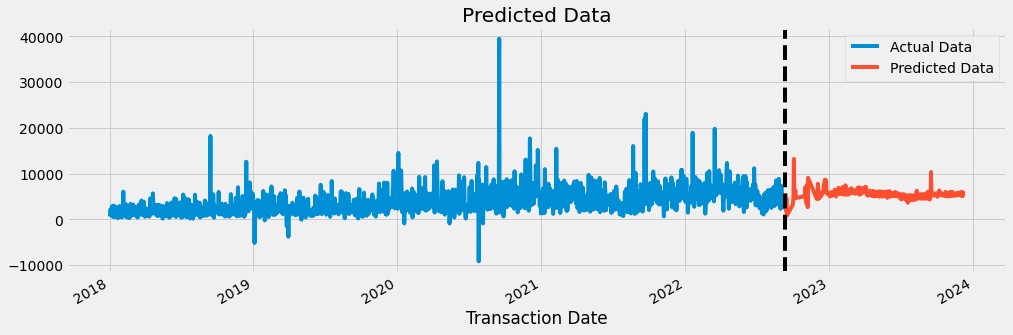

In [37]:
Actual = Historical_Pred_df.loc[df_Prediction.index < '09-12-2022']
Prediction = Historical_Pred_df.loc[df_Prediction.index >= '9-12-2022']

fig, ax = plt.subplots(figsize=(15, 5))
Actual.plot(ax=ax, label='Actual Data', title='Predicted Data')
Prediction.plot(ax=ax, label='Predicted Data')
ax.axvline('09-12-2022', color='black', ls='--')
ax.legend(['Actual Data', 'Predicted Data'])
plt.show()